In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.scipy.special import logsumexp
import optax
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 4)

In [48]:
from calibrated_response.models.variable import (Variable, BinaryVariable, ContinuousVariable)
from calibrated_response.maxent.constraints import (Constraint, 
    ConstraintSet, ProbabilityConstraint, MeanConstraint, 
    QuantileConstraint, ConditionalQuantileConstraint, ConditionalMeanConstraint,
    to_bins
)

# Define three variables: binary, continuous, binary
variables = [
    BinaryVariable(
        name="market_crash",
        description="Whether a major market crash occurs",
        importance=0.8,
        prior_probability=0.15,
        yes_label="crash",
        no_label="no crash",
        is_target=False
    ),
    ContinuousVariable(
        name="stock_return",
        description="Annual stock market return percentage",
        importance=0.9,
        lower_bound=-50,
        upper_bound=100,
        unit="percent",
        is_target=False
    )
]

print(f"Variables: {[v.name for v in variables]}")
for v in variables:
    print(f"  - {v.name} ({v.type}): {v.description}")

constraints = [
    # Constraints on stock_return (variable index 1)
    # MeanConstraint(
    #     id="mean_return",
    #     target_variable=variables[1],
    #     mean=8.0,
    #     confidence=0.85,
    #     source_query_id="q1"
    # ),
    QuantileConstraint(
        id='no_crash_likelihood',
        target_variable=variables[0],
        quantile=0.85,
        value=0,
        confidence=0.8,
        source_query_id="q4"
    ),
    ConditionalQuantileConstraint(
        id='return_quantile_given_no_crash',
        target_variable=variables[1],
        quantile=0.4,
        value=0,
        condition_variables=[variables[0]],
        condition_values=[0.0],
        is_lower_bound=[False],
        confidence=0.8,
        source_query_id="q6"
    ),
    ConditionalMeanConstraint(
        id='return_mean_given_crash',
        target_variable=variables[1],
        value=-20,
        condition_variables=[variables[0]],
        condition_values=[0.0],
        is_lower_bound=[True],
        confidence=0.8,
        source_query_id="q6"
    ),
    ConditionalMeanConstraint(
        id='return_mean_given_no_crash',
        target_variable=variables[1],
        value=50,
        condition_variables=[variables[0]],
        condition_values=[0.0],
        is_lower_bound=[False],
        confidence=0.8,
        source_query_id="q6"
    )
]

print(f"Created {len(constraints)} constraints:")
for i, c in enumerate(constraints):
    print(f"  {i+1}. {c.id} on '{c.target_variable.name}': target={c.target_value()}, confidence={c.confidence}")

Variables: ['market_crash', 'stock_return']
  - market_crash (binary): Whether a major market crash occurs
  - stock_return (continuous): Annual stock market return percentage
Created 4 constraints:
  1. no_crash_likelihood on 'market_crash': target=0.85, confidence=0.8
  2. return_quantile_given_no_crash on 'stock_return': target=0.4, confidence=0.8
  3. return_mean_given_crash on 'stock_return': target=-20.0, confidence=0.8
  4. return_mean_given_no_crash on 'stock_return': target=50.0, confidence=0.8


In [49]:
from calibrated_response.maxent.multivariate_solver import MultivariateMaxEntSolver, JAXSolverConfig
config = JAXSolverConfig(verbose=False, constraint_weight=1.0, regularization=1e-6)
solver = MultivariateMaxEntSolver(config=config)
p_optimal, bin_edges_list, info = solver.solve(variables, constraints)

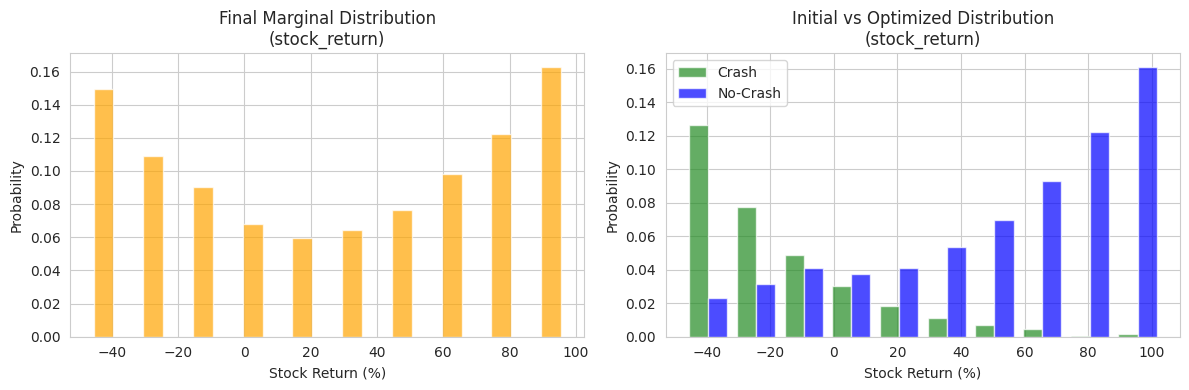

In [51]:
from calibrated_response.maxent.multivariate_solver import extract_marginal
# Plot optimization convergence
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
# Compare initial vs final marginals for stock_return
var_idx = 1  # stock_return
bins = bin_edges_list[var_idx]
bin_centers = (bins[:-1] + bins[1:]) / 2

# initial_marginal = extract_marginal(p0, var_idx)
final_marginal = extract_marginal(p_optimal, var_idx)
axes[0].bar(bin_centers, final_marginal, width=(bins[1]-bins[0])*0.4, alpha=0.7, label='Final', color='orange')
axes[0].set_xlabel('Stock Return (%)')
axes[0].set_ylabel('Probability')
axes[0].set_title('Final Marginal Distribution\n(stock_return)')

crash_distr = p_optimal[1, :]
no_crash_distr = p_optimal[0, :]

width = (bins[1] - bins[0]) * 0.4
axes[1].bar(bin_centers, crash_distr, width=width, alpha=0.7, label='Crash', color='forestgreen')
axes[1].bar(bin_centers + width, no_crash_distr, width=width, alpha=0.7, label='No-Crash', color='blue')
axes[1].set_xlabel('Stock Return (%)')
axes[1].set_ylabel('Probability')
axes[1].set_title('Initial vs Optimized Distribution\n(stock_return)')
axes[1].legend()

plt.tight_layout()
plt.show()